In [27]:
%matplotlib inline
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from scipy import interpolate
from scipy.fftpack import fft,ifft
from numpy.fft import rfft,irfft
from scipy.cluster.vq import vq,kmeans,whiten
from scipy import conj,argmax
from scipy.signal import periodogram

In [28]:
# Set the log file path
logFileName = '000-beetle-1.53-4.1'
logFileType = '.BBL'
logFilePath = logFileName+logFileType

# Set the blackbox_decode path
decodePath = 'blackbox_decode.exe'

# Create decode command
decodeCommand = decodePath + ' ' + logFilePath
#print(cmd)

In [29]:
dataFile = logFileName+'.01.csv'

df=pd.read_csv(dataFile) 
#df.head()
loopIteration   = df[ 'loopIteration'].values.T
time            = df[ ' time (us)'].values.T
#print(time[0])
time=time-time[0]
#print(time)
diffOfTime = np.diff(time)
#print(diffOfTime)
averageUs = np.median(diffOfTime)
#print(averageUs)
samplingRate = 1000000/averageUs
print(samplingRate)

2000.0


In [32]:
df.columns
setpointData    = df[[ ' setpoint[0]',  ' setpoint[1]', ' setpoint[2]']].values.T
gyroADCData     = df[[ ' gyroADC[0]',   ' gyroADC[1]',  ' gyroADC[2]']].values.T
gyroScaleData   = df[[ ' debug[0]',     ' debug[1]',    ' debug[2]']].values.T
thrData         = df[[ ' rcCommand[3]']].values.T[0]
#print(setpointData)
#print(gyroADCData)
print(gyroScaleData)
print(thrData)

[[  9   8   5 ... -16 -13  -9]
 [  5   4   3 ...   1   1   1]
 [  2   1  -1 ...   0   6   7]]
[1000 1000 1000 ... 1000 1000 1000]


In [63]:
signal = gyroScaleData[0]
bufferSize = 1024
batch = int(len(signal)/bufferSize)
thrPsd = np.zeros((100, int(bufferSize/2)+1), dtype=np.float64)
thrCount = np.zeros(100, dtype=np.int32)
thr = thrData/10 - 100

for i in range(0, len(signal)-bufferSize, 10):
    idx = i
    avgThr = int(np.mean(thr[idx:idx+bufferSize]))
    if avgThr < 0:
        avgThr = 0
    if avgThr > 99:
        avgThr = 99
    f, Pxx_den = periodogram(signal[idx:idx+bufferSize], samplingRate, window=('kaiser',8.5), detrend='constant', return_onesided=True, scaling='density', axis=- 1)
    #print(len(Pxx_den))
    #print(max(f))
    #break
    thrPsd[avgThr]= thrPsd[avgThr]+Pxx_den
    thrCount[avgThr] += 1
    
for i in range(100):
    if thrCount[i] != 0:
        thrPsd[i]=thrPsd[i]/thrCount[i]

In [89]:
thr_psd = np.log10(thrPsd)
maxdb = np.zeros(100, dtype=np.float64)
mindb = np.zeros(100, dtype=np.float64)
hz = np.zeros(100, dtype=np.int32)
j=0
for i in range(0,99,1):
    maxdb[j] = max(thr_psd[i,50:])
    hz[j] = argmax(thr_psd[i,50:])
    j += 1
k=0
for i in range(0,99,1):
    mindb[k] = min(thr_psd[i,25:])
    k += 1
#maxdb = max(thr_psd[10,25:])

print(max(maxdb))
print(argmax(maxdb))
print(hz[argmax(maxdb)])
print(min(mindb))
print(argmax(-mindb))

1.3866863050785445
9
49
-4.869786538714944
98


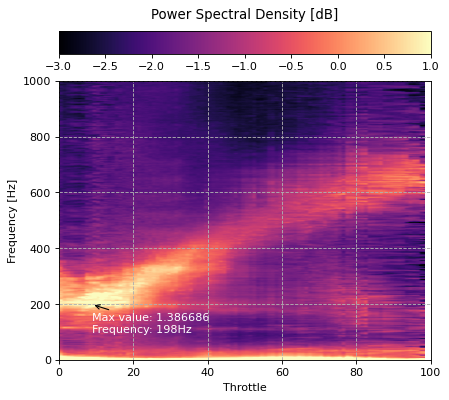

In [103]:
plt.figure(figsize=(6, 7), dpi= 80)
plt.imshow(thr_psd.T, cmap='magma', vmin=-3, vmax=1, aspect=0.075, interpolation='kaiser', origin='lower', extent=[0, 100, 0, samplingRate/2])

plt.grid(True,linestyle='--')
plt.title('Power Spectral Density [dB]', y=1.2)
plt.xlabel('Throttle')
plt.ylabel('Frequency [Hz]')

text = (     'Max value: %f \nFrequency: %dHz' %(   max(maxdb) ,   2*(50+hz[argmax(maxdb)])   )     )
plt.plot(argmax(maxdb), max(maxdb)*2, 'g')
plt.annotate(text, c='w', xy=(argmax(maxdb), 2*(50+hz[argmax(maxdb)])), xytext=(argmax(maxdb), (50+hz[argmax(maxdb)])), arrowprops=dict(arrowstyle='->'))

position= plt.axes([0.125, 0.8, 0.775, 0.04])
plt.colorbar(cax=position,orientation='horizontal')
plt.show()

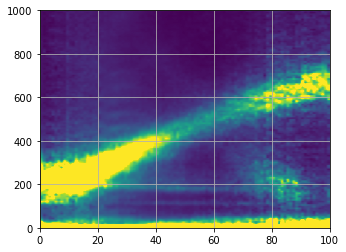

In [24]:
signal = gyroScaleData[0]
thr = thrData #1000~2000
bufferSize = 256
batch = int(len(signal)/bufferSize)
thrfft = np.zeros((100, int(bufferSize/2)), dtype=np.float64)
#timefft = np.zeros((len(signal)-bufferSize, int(bufferSize/2)), dtype=np.float64)
thrCount = np.zeros(100, dtype=np.int32)

#print(thr)
#print(batch)

for i in range(0, len(signal)-bufferSize, 10):
    idx = i
    #print(np.sum(thr[idx:idx+bufferSize])/bufferSize)
    avgThr = int(np.sum(thr[idx:idx+bufferSize])/bufferSize/10) - 100
    if avgThr < 0:
        avgThr = 0
    if avgThr > 99:
        avgThr = 99
    #print(avgThr)
    fft_data = fft(np.hanning(bufferSize) * signal[idx:idx+bufferSize], bufferSize)
    realPart = np.abs(np.real(fft_data[:int(bufferSize/2)]))/bufferSize*2
    #timefft[i]+=realPart
    thrfft[avgThr]= thrfft[avgThr]+realPart
    thrCount[avgThr] += 1
    
for i in range(100):
    if thrCount[i] != 0:
        thrfft[i]=thrfft[i]/thrCount[i]
#print(thrfft)
#plt.imshow(bitmap)
#plt.hist(bitmap, bins=256, range=(0.0, 256.0))

#plt.figure(figsize=(2, 14), dpi= 80)
plt.imshow(thrfft.T, cmap='viridis', vmax=1, aspect=0.075, interpolation='kaiser', origin='lower', extent=[0, 100, 0, samplingRate/2])
plt.grid(True,linestyle='-')

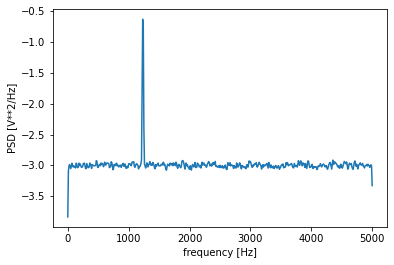

In [25]:
from scipy import signal
import matplotlib.pyplot as plt
np.random.seed(1234)

fs = 10e3
N = 1e5
amp = 2*np.sqrt(2)
freq = 1234.0
noise_power = 0.001 * fs / 2
time = np.arange(N) / fs
x = amp*np.sin(2*np.pi*freq*time)
x += np.random.normal(scale=np.sqrt(noise_power), size=time.shape)

f, Pxx_den = signal.welch(x, fs, nperseg=1024)
#plt.semilogy(f, Pxx_den)
Pxx_den = (np.log10(Pxx_den))
plt.plot(f, Pxx_den)
#plt.ylim([0.5e-3, 1])
plt.xlabel('frequency [Hz]')
plt.ylabel('PSD [V**2/Hz]')
plt.show()